<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

**Nota: los modelos de esta sección fueron entrenados en el servidor del Laboratorio de Inteligencia Computacional Avanzada (INCA), por lo que en este notebook tan sólo se mostrarán los resultados obtenidos. 
La siguiente es la función utilizada en el servidor para construir los modelos y guardar los resultados obtenidos:**

```python
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1,l2


datos = pd.read_csv("roboBohr.csv")

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total = len(datos)
df_train = datos[:int(0.6*total)]                       #60% de los datos
df_validation = datos[int(0.6*total):int(0.85*total)]        #25% de los datos
df_test = datos[int(0.85*total)::]                     #15% restante

# Get scaler and scale data
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_validation_scaled = pd.DataFrame(scaler.transform(df_validation),columns=df_validation.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
# Get targets
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
y_validation_scaled =X_validation_scaled.pop('Eat').values.reshape(-1,1)
y_test_scaled = X_test_scaled.pop('Eat').values.reshape(-1,1)

n_layers = int(sys.argv[1])
initializer = sys.argv[2]
activation = sys.argv[3]
name = sys.argv[4]
lr = float(sys.argv[5])
epochs = int(sys.argv[6])
    
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer=initializer,activation=activation))

for i in range(n_layers):
    model.add(Dense(256,kernel_initializer=initializer,activation=activation))
model.add(Dense(1,kernel_initializer=initializer,activation = 'linear' ))
sgd = Adam(lr=lr)
model.compile(optimizer=sgd,loss='mean_squared_error')
model.save('pre_train_'+str(name)+'.h5')
history = model.fit(X_train_scaled,y_train_scaled, epochs = epochs, batch_size = 64)
model.save('post_train_'+str(name)+'.h5')
np.savetxt('history_'+str(name)+'.txt',history.history['loss'])
```

In [299]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_gradients(old_gradients, new_gradients, layers_to_plot, sharex=None):
    
    l = len(layers_to_plot)
    f, axes = plt.subplots(2, l ,figsize=(20,8), **({} if sharex is None else {'sharex':sharex}))

    
    for j in range(2):
        for i,index in enumerate(layers_to_plot):
            if j == 0:
                axes[j,i].hist(old_gradients[index*2].flatten(), bins = 30)
                axes[j,i].set_title('Gradientes pre entreno capa'+str(index+1))
            if j == 1:
                axes[j,i].hist(new_gradients[index*2].flatten(), bins = 30)
                axes[j,i].set_title('Gradientes post entreno capa'+str(index+1))
                axes[j,i].set_xticks(axes[j,i].get_xticks()[::(len(axes[j,i].get_xticks())+5-1)//5])
        
    plt.show()

In [121]:
def compute_gradients(model,y_train_scaled):
    loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
    listOfVariableTensors = model.trainable_weights 
    gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
    evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
    return evaluated_gradients

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1,l2

import matplotlib.pyplot as plt

from ipywidgets import interact

Using TensorFlow backend.


a) Se trabajará con las etiquetas escaladas uniformemente, es decir,  𝜇=0  y  𝜎=1 , ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.

In [11]:
datos = pd.read_csv("roboBohr.csv")

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total = len(datos)
df_train = datos[:int(0.6*total)]                       #60% de los datos
df_validation = datos[int(0.6*total):int(0.85*total)]        #25% de los datos
df_test = datos[int(0.85*total)::]                     #15% restante

# Get scaler and scale data
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_validation_scaled = pd.DataFrame(scaler.transform(df_validation),columns=df_validation.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
# Get targets
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
y_validation_scaled =X_validation_scaled.pop('Eat').values.reshape(-1,1)
y_test_scaled = X_test_scaled.pop('Eat').values.reshape(-1,1)

b) Para el mismo problema definido anteriormente (sección 1) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (loss) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de gradients (link) en el backend de Keras. Deberá generar un histograma para todos los pesos de cada capa antes y despues del entrenamiento con 250 epochs. Comente.

In [261]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2b.h5')
post_train_model = load_model('post_train_2b.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2b.txt')

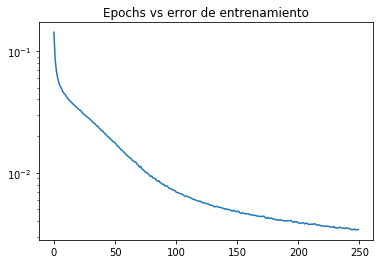

In [258]:
plt.semilogy(history)
plt.title('Epochs vs error de entrenamiento')
plt.show()

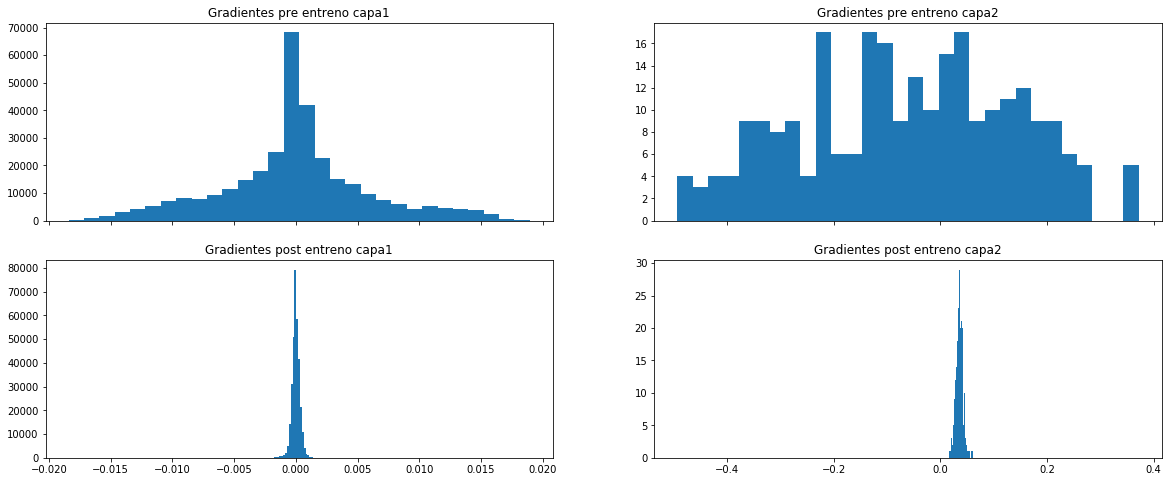

In [265]:
plot_gradients(old_gradients, new_gradients, [0,1])

Se observa que los gradientes, antes de entrenar el modelo, están distribuidos alrededor del 0 con una dispersión sustancialmente más grande que después de entrenar el modelo. Esto se condice con el gráfico de convergencia del entrenamiento: como los gradientes tienden a 0, los pesos se ajustan cada vez menos y por ende el error de entrenamiento disminuye su variación. 

c)  Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.

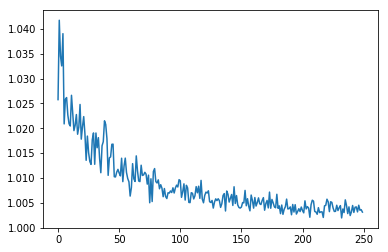

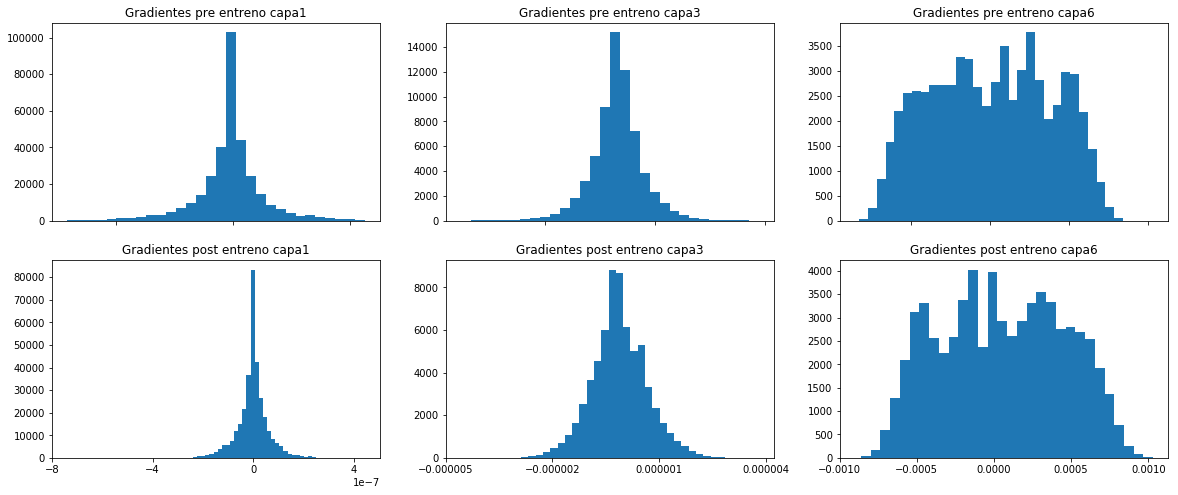

In [289]:
pre_train_model = load_model('pre_train_2c.h5')
post_train_model = load_model('post_train_2c.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2c.txt')
plt.plot(history)
plt.show()
plot_gradients(old_gradients, new_gradients, [0,2,5])


Se observa que los gradientes asociados a los pesos que conectan la capa de entrada con la primera capa oculta son extremadamente pequeños, tanto antes de entrenar como después de entrenar. Los gradientes pequeños impidieron el aprendizaje de características de la primera capa oculta, por lo cual, cualquier aprendizaje asociado a las capas posteriores es insignificativo. Lo anterior se evidencia al observar los gradientes en cada capa: no hay aprendizaje en ningún caso, ya que  las capas ocultas se tratan de construir nuevas representaciones a partir de las capas previas, las cuales no han aprendido ninguna representación válida. 

d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.

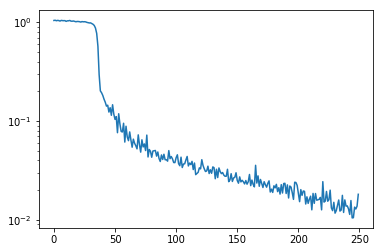

In [290]:
pre_train_model = load_model('pre_train_2d.h5')
post_train_model = load_model('post_train_2d.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2d.txt')

plt.semilogy(history)

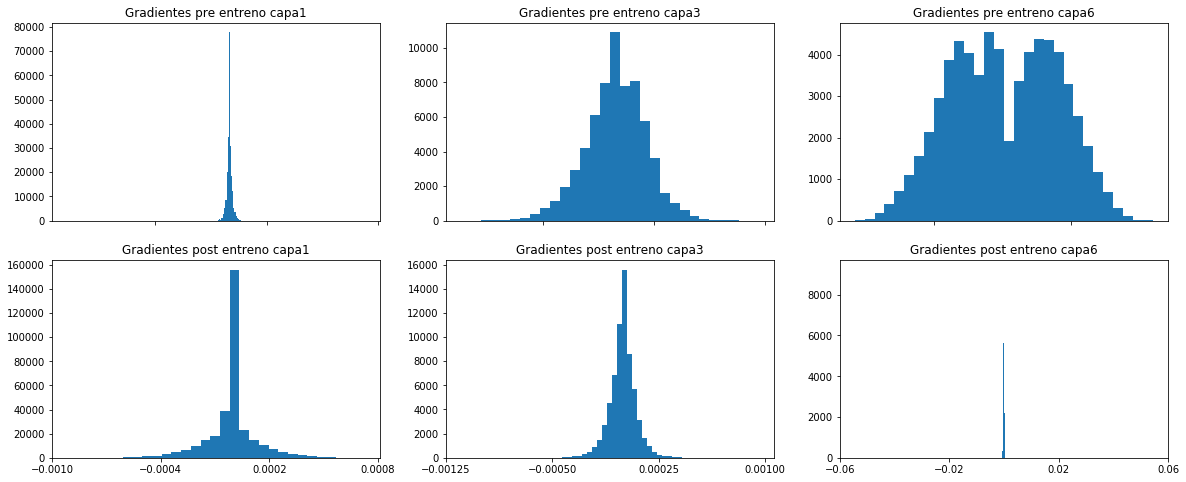

In [293]:
plot_gradients(old_gradients, new_gradients, [0,2,5])

En este caso, utilizando la inicialización de Glorot, después de aproximadamente 40 epochs el error se escapa del óptimo local inicial al cual había llegado. Se observa que hubo una copiosa disminución en la magnitud de los gradientes de la última capa. Después del entrenamiento, la magnitud de los gradientes de las diversas capas es similar, lo cual lleva a que los pesos se actualicen en medida similares, lo cual puede ser la causa de la inestabilidad en el error de entrenamiento que se observa en los últimos epochs

 e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

Utilizando el learning rate de 0.01 con la inicialización uniforme y activaciones ReLu, la red diverge, por lo cual hemos disminuido el learning rate a 0.001. Con esta disminución observamos que esta vez la red no diverge: pareciera ser que la divergencia de los gradientes fue anulada por la apropiada disminución del learning rate.

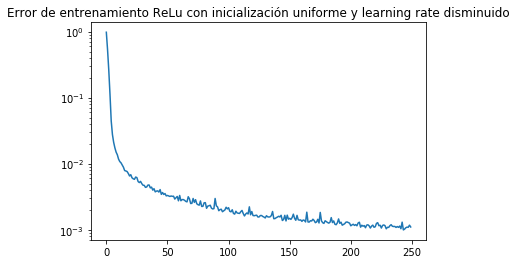

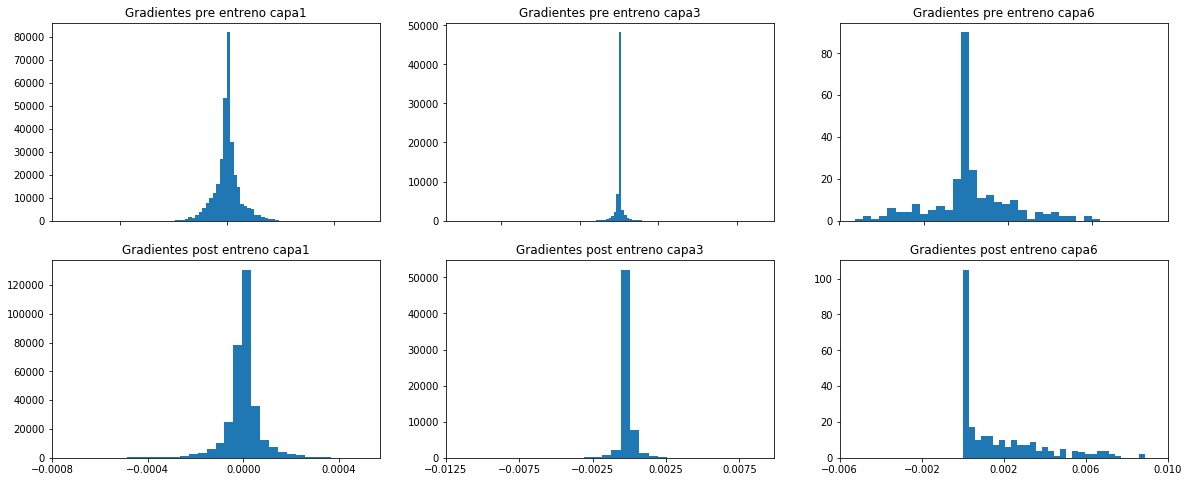

In [295]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2e_uniform.h5')
post_train_model = load_model('post_train_2e_uniform.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2euniform.txt')

plt.semilogy(history)
plt.title('Error de entrenamiento ReLu con inicialización uniforme y learning rate disminuido')
plot_gradients(old_gradients, new_gradients, [0,2,5])

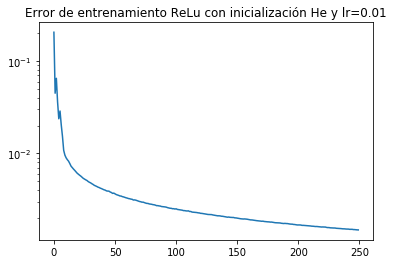

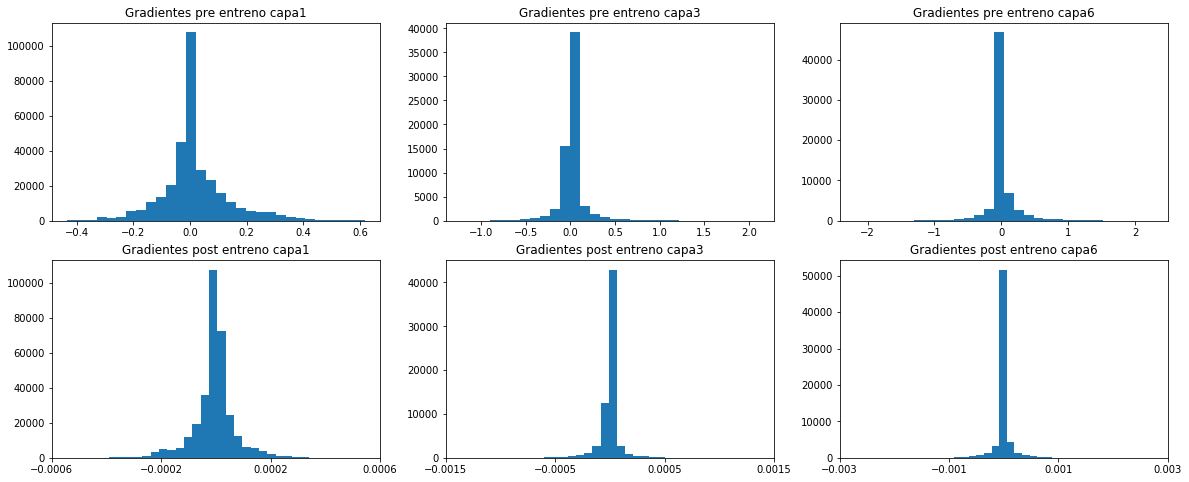

In [298]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2e.h5')
post_train_model = load_model('post_train_2e.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2e.txt')

plt.semilogy(history)
plt.title('Error de entrenamiento ReLu con inicialización He y lr=0.01')
plot_gradients(old_gradients, new_gradients, [0,2,5])

En este caso se puede ver que la **he**, a diferencia de la **uniform**, no sufre de la divergencia de los gradientes, dado el learning rate de 0.01, producto de que fue pensada para preservar la varianza de las activaciones **relu** a través de las capas.

Las **sigmoides** suelen sufrir los efectos del gradiente desvaneciente de todas maneras, independiente de la inicialización de los pesos. En el caso de la ReLu, como podemos ver, no fue necesario variar la learning rate, y la magnitud de los gradientes revela que hubo aprendizaje, ya que después de las 250 epochs, son órdenes de magnitud más pequeños que los originales.

f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

Se observa, de la pregunta anterior, que la red logra convergencia en el entrenamiento. Observamos de la pregunta  1) anterior que el learning rate es uno de los factores más importantes en cuanto a la convergencia tanto del error de training como el de validación. Por ende, para lograr un error de test menor al de la red shallow de la pregunta b), disminuiremos el learning rate a la vez que aumentamos la cantidad de epochs para evitar el underfitting.  Los parámetros de los modelos que probaremos son:

- Learning rate 0.01 con 20 epochs.
- Learning rate 0.001 con 50 epochs.
- Learning rate 0.0005 con 100 epochs.

Todos los modelos utilizan inicialización de He y el algoritmo de aprendizaje Adam.

In [243]:
baseline_model = load_model('post_train_2b.h5')

model1 = load_model('post_train_2f_he_uniform_relu_0.01_20.h5')
model2 = load_model('post_train_2f_he_uniform_relu_0.001_50.h5')
model3 = load_model('post_train_2f_he_uniform_relu_0.0005_100.h5')

In [300]:
print("modelo shallow")
print(baseline_model.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))
print("modelo 1")
print(model1.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))
print("modelo 2")
print(model2.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))
print("modelo 3")
print(model3.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))

modelo shallow
0.00556677556986659
modelo 1
0.008080263608341734
modelo 2
0.004239855989299972
modelo 3
0.0038002369189038504


Observamos que se alcanza un menor error de validación con el segundo y tercer modelo. Elegimos el **modelo 3** para comparar sobre el test set con el modelo base de 1 capa.

In [301]:
print("Test error con modelo shallow")
print(baseline_model.evaluate(X_test_scaled,y_test_scaled, verbose = 0))
print("Test error con modelo modelo 3")
print(model3.evaluate(X_test_scaled,y_test_scaled, verbose = 0))

Test error con modelo shallow
0.005365086902257026
Test error con modelo modelo 3
0.002082822358948062


Observamos una clara victoria de parte del modelo 3, el cual aprovechó su mayor capacidad de modelamiento, dada por su arquitectura profunda, y la habilidad de las relu de evitar el problema del gradiente.

 g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.

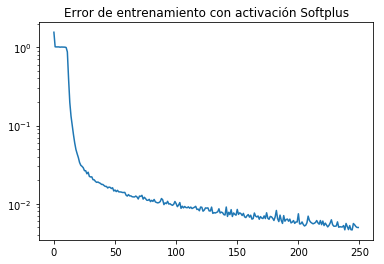

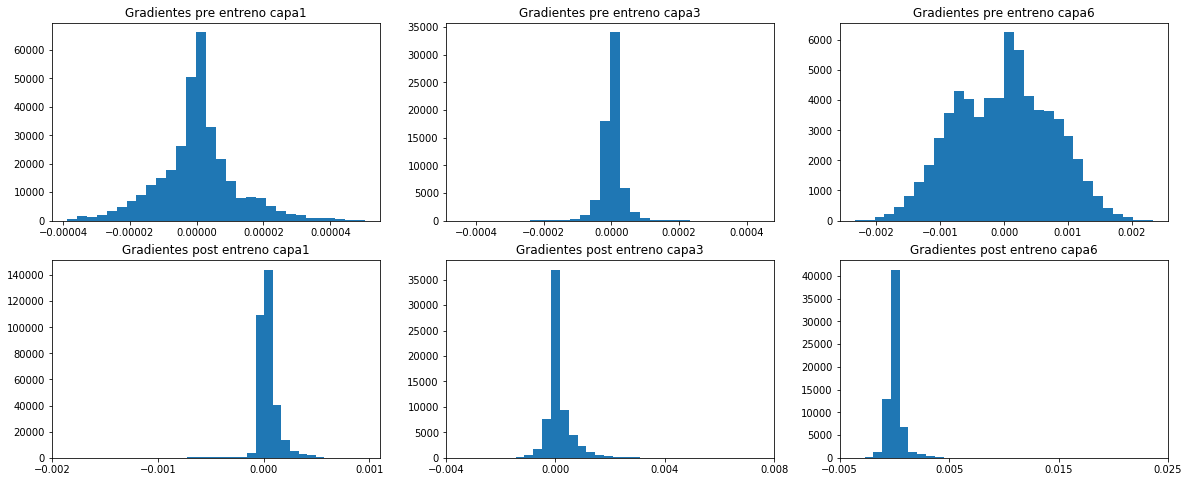

In [302]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2g_uniform.h5')
post_train_model = load_model('post_train_2g_uniform.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2g_uniform.txt')

plt.semilogy(history)
plt.title('Error de entrenamiento con activación Softplus')
plot_gradients(old_gradients, new_gradients, [0,2,5])

Teóricamente existe el beneficio de que es diferenciable en todo el dominio, sin embargo, en la práctica este beneficio no ayuda al entrenamiento, ni tampoco lo hizo aquí.

h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?

El modelo diverge dada un lr=0.01 independiente de la función de activación y de la inicialización utilizada. La gran cantidad de neuronas de la capa intermedia genera el efecto de magnificar las activaciones y con ello magnificar la salida del modelo. Esto se traduce, a su vez, en gradientes muy grandes que llevan a la divergencia del modelo rápidamente. Nuevamente, al disminuir el learning rate este fenómeno se puede evitar debido a que amortigua la actualización de los pesos.